In [1]:
import numpy as np
import pandas as pd
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (
    Input, Dense, Flatten, Conv1D, MaxPooling1D, GlobalAveragePooling1D,
    Multiply, Reshape, add, Activation
)
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
import tensorflow as tf

In [2]:
def load_file(filepath):
    dataframe = pd.read_csv(filepath, header=None, delim_whitespace=True)
    return dataframe.values

In [3]:
def load_group(filenames, prefix=''):
    loaded = [load_file(prefix + name) for name in filenames]
    loaded = np.dstack(loaded)
    return loaded

In [4]:
def load_dataset_group(group, prefix=''):
    filepath = prefix + group + '/Inertial Signals/'
    filenames = [
        'total_acc_x_'+group+'.txt', 'total_acc_y_'+group+'.txt', 'total_acc_z_'+group+'.txt',
        'body_acc_x_'+group+'.txt', 'body_acc_y_'+group+'.txt', 'body_acc_z_'+group+'.txt',
        'body_gyro_x_'+group+'.txt', 'body_gyro_y_'+group+'.txt', 'body_gyro_z_'+group+'.txt'
    ]
    X = load_group(filenames, filepath)
    y = load_file(prefix + group + '/y_'+group+'.txt')
    return X, y

In [5]:
def load_dataset(prefix=''):
    trainX, trainy = load_dataset_group('train', prefix + '/content/drive/MyDrive/2025-2 MLP/source/UCI HAR Dataset/UCI HAR Dataset/')
    testX, testy = load_dataset_group('test', prefix + '/content/drive/MyDrive/2025-2 MLP/source/UCI HAR Dataset/UCI HAR Dataset/')
    trainy = trainy - 1
    testy = testy - 1
    trainy_one_hot = to_categorical(trainy)
    testy_one_hot = to_categorical(testy)
    return trainX, trainy, trainy_one_hot, testX, testy, testy_one_hot

In [6]:
trainX, trainy, trainy_one_hot, testX, testy, testy_one_hot = load_dataset()

/tmp/ipython-input-1098839523.py:2: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  dataframe = pd.read_csv(filepath, header=None, delim_whitespace=True)
/tmp/ipython-input-1098839523.py:2: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  dataframe = pd.read_csv(filepath, header=None, delim_whitespace=True)
/tmp/ipython-input-1098839523.py:2: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  dataframe = pd.read_csv(filepath, header=None, delim_whitespace=True)
/tmp/ipython-input-1098839523.py:2: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  dataframe = pd.read_csv(filepath, header=None, delim_whitespace=True)


In [7]:
X_train, X_val, y_train_one_hot, y_val_one_hot, y_train, y_val = train_test_split(
    trainX, trainy_one_hot, trainy, test_size=0.2, random_state=100
)

n_timesteps, n_features, n_outputs = X_train.shape[1], X_train.shape[2], y_train_one_hot.shape[1]

In [8]:
def se_block(input_tensor, ratio=16):
    filters = input_tensor.shape[-1]
    se = GlobalAveragePooling1D()(input_tensor)
    se = Dense(filters // ratio, activation='relu')(se)
    se = Dense(filters, activation='sigmoid')(se)
    se = Reshape((1, filters))(se)
    x = Multiply()([input_tensor, se])
    return x

In [9]:
def residual_block(input_tensor, filters, kernel_size=3):
    x = Conv1D(filters, kernel_size, padding='same', activation='relu')(input_tensor)
    x = Conv1D(filters, kernel_size, padding='same')(x)
    x = se_block(x)  # Residual Block 안에 SE 추가
    x = add([x, input_tensor])
    x = Activation('relu')(x)
    return x

In [10]:
inputs = Input(shape=(n_timesteps, n_features))
x = Conv1D(64, 3, padding='same', activation='relu')(inputs)
x = residual_block(x, 64)
x = residual_block(x, 64)
x = MaxPooling1D(pool_size=2)(x)

x = Conv1D(128, 3, padding='same', activation='relu')(x)
x = residual_block(x, 128)
x = residual_block(x, 128)
x = MaxPooling1D(pool_size=2)(x)

x = Flatten()(x)
x = Dense(512, activation='relu')(x)
outputs = Dense(n_outputs, activation='softmax')(x)

se_resnet_model = Model(inputs, outputs)
se_resnet_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
se_resnet_model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 128, 9)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d (Conv1D)     │ (None, 128, 64)   │      1,792 │ input_layer[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_1 (Conv1D)   │ (None, 128, 64)   │     12,352 │ conv1d[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_2 (Conv1D)   │ (None, 128, 64)   │     12,352 │ conv1d_1[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 64)        │          0 │ conv1d_2[0][0]    │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 4)         │        260 │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 64)        │        320 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape (Reshape)   │ (None, 1, 64)     │          0 │ dense_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multiply (Multiply) │ (None, 128, 64)   │          0 │ conv1d_2[0][0],   │
│                     │                   │            │ reshape[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 128, 64)   │          0 │ multiply[0][0],   │
│                     │                   │            │ conv1d[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 128, 64)   │          0 │ add[0][0]         │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_3 (Conv1D)   │ (None, 128, 64)   │     12,352 │ activation[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_4 (Conv1D)   │ (None, 128, 64)   │     12,352 │ conv1d_3[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 64)        │          0 │ conv1d_4[0][0]    │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 4)         │        260 │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 64)        │        320 │ dense_2[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape_1 (Reshape) │ (None, 1, 64)     │          0 │ dense_3[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multiply_1          │ (None, 128, 64)   │          0 │ conv1d_4[0][0],   │
│ (Multiply)          │                   │            │ reshape_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_1 (Add)         │ (None, 128, 64)   │          0 │ multiply_1[0][0], │
│                     │                   │            │ activation[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_1        │ (None, 128, 64)   │          0 │ add_1[0][0]       │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 2,379,294 (9.08 MB)

 Trainable params: 2,379,294 (9.08 MB)

 Non-trainable params: 0 (0.00 B)

In [11]:
model_history = se_resnet_model.fit(
    X_train,
    y_train_one_hot,
    epochs=30,
    batch_size=32,
    validation_split=0.1
)

Epoch 1/30
166/166 ━━━━━━━━━━━━━━━━━━━━ 30s 138ms/step - accuracy: 0.7231 - loss: 0.6752 - val_accuracy: 0.9542 - val_loss: 0.1183
Epoch 2/30
166/166 ━━━━━━━━━━━━━━━━━━━━ 23s 135ms/step - accuracy: 0.9465 - loss: 0.1303 - val_accuracy: 0.7844 - val_loss: 1.4518
Epoch 3/30
166/166 ━━━━━━━━━━━━━━━━━━━━ 24s 144ms/step - accuracy: 0.9309 - loss: 0.2064 - val_accuracy: 0.9423 - val_loss: 0.1200
Epoch 4/30
166/166 ━━━━━━━━━━━━━━━━━━━━ 22s 130ms/step - accuracy: 0.9569 - loss: 0.0997 - val_accuracy: 0.9525 - val_loss: 0.1017
Epoch 5/30
166/166 ━━━━━━━━━━━━━━━━━━━━ 23s 140ms/step - accuracy: 0.9594 - loss: 0.0954 - val_accuracy: 0.9508 - val_loss: 0.1112
Epoch 6/30
166/166 ━━━━━━━━━━━━━━━━━━━━ 41s 140ms/step - accuracy: 0.9547 - loss: 0.1074 - val_accuracy: 0.9542 - val_loss: 0.1015
Epoch 7/30
166/166 ━━━━━━━━━━━━━━━━━━━━ 25s 150ms/step - accuracy: 0.9575 - loss: 0.1066 - val_accuracy: 0.9491 - val_loss: 0.0935
Epoch 8/30
166/166 ━━━━━━━━━━━━━━━━━━━━ 39s 140ms/step - accuracy: 0.9550 - loss: 0

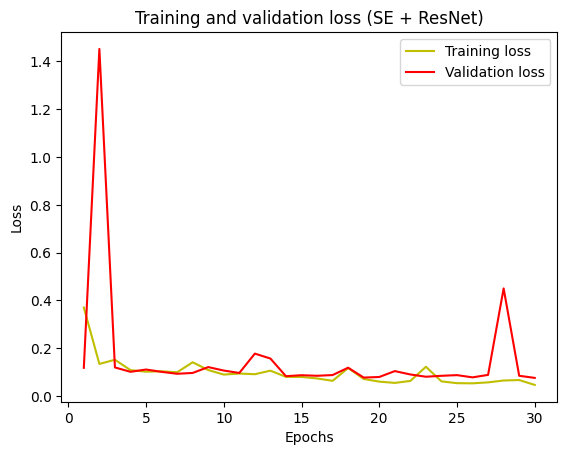

In [12]:
loss = model_history.history['loss']
val_loss = model_history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss (SE + ResNet)')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

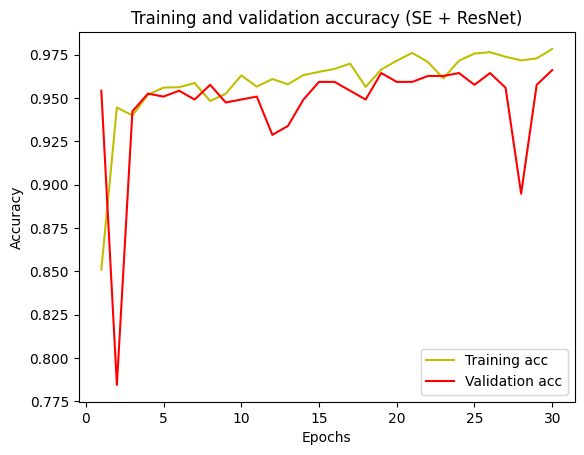

In [13]:
acc = model_history.history['accuracy']
val_acc = model_history.history['val_accuracy']
plt.plot(epochs, acc, 'y', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy (SE + ResNet)')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

93/93 ━━━━━━━━━━━━━━━━━━━━ 3s 34ms/step
[[492   0   4   0   0   0]
 [  5 440  26   0   0   0]
 [  7   1 412   0   0   0]
 [  0   1   0 397  93   0]
 [  1   0   0  96 435   0]
 [  0  27   0   0   0 510]]
0.9114353579911775
              precision    recall  f1-score   support

           0       0.97      0.99      0.98       496
           1       0.94      0.93      0.94       471
           2       0.93      0.98      0.96       420
           3       0.81      0.81      0.81       491
           4       0.82      0.82      0.82       532
           5       1.00      0.95      0.97       537

    accuracy                           0.91      2947
   macro avg       0.91      0.91      0.91      2947
weighted avg       0.91      0.91      0.91      2947



<Axes: >

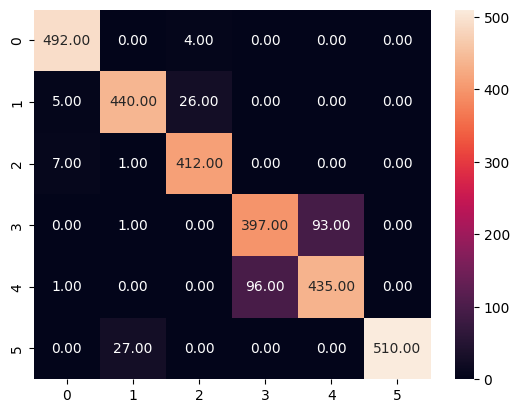

In [14]:
pred = se_resnet_model.predict(testX)
pred = np.argmax(pred, axis=-1)
cm = confusion_matrix(testy, pred)
print(cm)
print(accuracy_score(testy, pred))
print(classification_report(testy, pred))
sns.heatmap(cm, annot=True, fmt='.2f')